In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os
import cv2

%matplotlib inline 

In [2]:
df_all = pd.read_pickle(os.path.join(os.getcwd(), 'input\LSWMD.pkl'))
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
waferMap          811457 non-null object
dieSize           811457 non-null float64
lotName           811457 non-null object
waferIndex        811457 non-null float64
trianTestLabel    811457 non-null object
failureType       811457 non-null object
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [3]:
df_all['failureNum'] = df_all.failureType
df_all['trainTestNum'] = df_all.trianTestLabel

mapping_type={'Center':0,'Donut':1,'Edge-Loc':2,
              'Edge-Ring':3,'Loc':4,'Random':5,
              'Scratch':6,'Near-full':7,'none':8}

mapping_traintest = {'Training':0, 'Test':1}

df_all = df_all.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})

C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\pandas\core\internals.py:5152: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = op(a, b)
C:\Users\user\Anaconda3\envs\neuralnets\lib\site-packages\pandas\core\missing.py:51: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask = arr == x


In [4]:
df_withlabel = df_all[(df_all['failureNum'] >= 0) & df_all['failureNum'] <=8]
df_withlabel = df_withlabel.reset_index()

df_withpattern = df_all[(df_all['failureNum'] >= 0) & (df_all['failureNum'] <= 7)]
df_withpattern = df_withpattern.reset_index()

df_nopattern = df_all[(df_all['failureNum'] == 8)]

df_withlabel.shape, df_withpattern.shape, df_nopattern.shape

((811457, 9), (25519, 9), (147431, 8))

In [5]:
test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

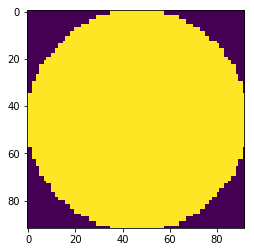

In [6]:
plt.imshow(test)

In [771]:
df_withpattern.to_pickle('test_wafer_map.pkl')

In [772]:
df_withpattern.iloc[0].to_pickle('test_wafer_map.pkl')

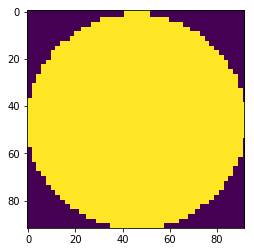

In [774]:
t = pd.read_pickle('test_wafer_map.pkl')
t = cv2.resize(t.waferMap, dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
t[t == 2] = 1
plt.imshow(t)

In [79]:
## индкы поля для синтеза кривых
i, j = np.where(test==1)

## Реализация кривых Безье 

In [682]:
def make_bezier(xys):
    # xys should be a sequence of 2-tuples (Bezier control points)
    n = len(xys)
    combinations = pascal_row(n-1)
    def bezier(ts):
        # This uses the generalized formula for bezier curves
        # http://en.wikipedia.org/wiki/B%C3%A9zier_curve#Generalization
        result = []
        for t in ts:
            tpowers = (t**i for i in range(n))
            upowers = reversed([(1-t)**i for i in range(n)])
            coefs = [c*a*b for c, a, b in zip(combinations, tpowers, upowers)]
            result.append(
                tuple(sum([coef*p for coef, p in zip(coefs, ps)]) for ps in zip(*xys)))
        return result
    return bezier

def pascal_row(n):
    # This returns the nth row of Pascal Triangle
    result = [1]
    x, numerator = 1, n
    for denominator in range(1, n//2+1):
        # print(numerator,denominator,x)
        x *= numerator
        x /= denominator
        result.append(x)
        numerator -= 1
    if n&1 == 0:
        # n is even
        result.extend(reversed(result[:-1]))
    else:
        result.extend(reversed(result)) 
    return result

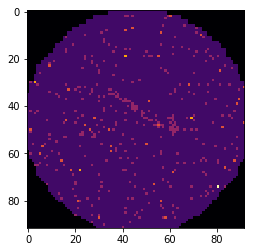

In [753]:
test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 

## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1

ts = [t/100.0 for t in range(0, 101)]
xys = [(33, 33), (44, 54), (60, 66), (44,60)]
bezier = make_bezier(xys)
points = bezier(ts)

for idx in points:
    i, j = idx
    i = round(i)
    j = round(j)
    test[i, j] = 2
    
import cv2
## сверткой расширим
kernel = np.ones((3,3), np.uint8)
kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 0, 0]], dtype=np.uint8)
test = cv2.dilate(test,kernel,iterations = 1)

## внесем шум
noise_img = test.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
mask[noise_img == 0] = False
r = np.random.poisson(lam=0.5, size=noise_img.shape)
# нормировка на шумы
# r = np.around(r//np.max(r))
r[r==0] = 1
noise_img[mask] = r[mask]
    
plt.imshow(noise_img, cmap='inferno')

### Тест кольца

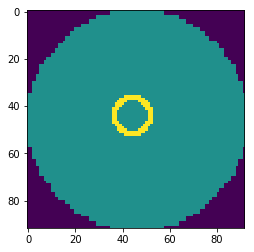

In [78]:
## параметры кольца
phi = np.linspace(0, np.pi*2, 200)
r = np.linspace(7, 8, 200)
xc = 44
yc = 44

## синтез сетки
R, Fi = np.meshgrid(r, phi)
X = R*(np.cos(Fi)) + xc
Y = R*(np.sin(Fi)) + yc
X_ = np.around(X)
Y_ = np.around(Y)

## индексы для полигона
points = []
for i in range(X_.shape[0]):
    for j in range(X_.shape[1]):
        x = X_[i,j]
        y = Y_[i,j]
        points.append((x,y))

## создадим тестовый полигон
test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
## 2 - паттерн
## 1 - фон
## 0 - область, где нет ничего
test[test == 2] = 1
for idx in points:
    i, j = idx
    i = int(round(i))
    j = int(round(j))
    test[i, j] = 2
    
plt.imshow(test);

## Кольца с шумом Пуассона

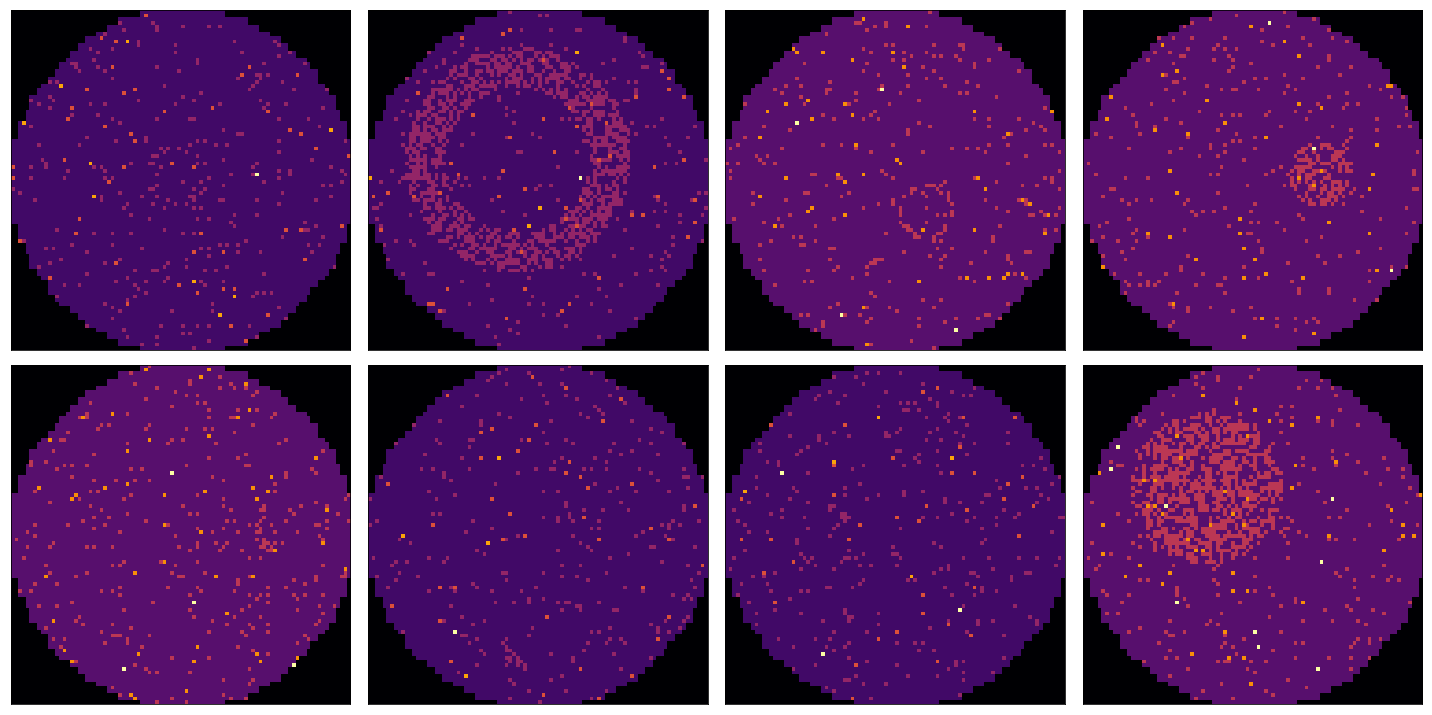

In [548]:
PHI = [(0, np.pi*2), (0, np.pi*2), (0, np.pi*2), (0, np.pi*2),
      (np.pi*1.25, np.pi*1.8), (np.pi*1.5, np.pi*2), (np.pi*1.75, np.pi*2), (0, np.pi*2)]

R_ = [(7, 8.5), (20, 30), (7, 7), (2, 8),
    (7, 8), (7, 8), (7, 8), (0, 20)]

XC = [44 ,40, 54, 44, 44, 74, 33, 33]
YC = [44 ,40, 54, 64, 74, 44, 33, 33]
## интесивность
N = [20, 200, 200, 200, 200, 200, 200, 200]

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for n in range(8):
    ## параметры кольца
    phi = np.linspace(PHI[n][0], PHI[n][1], N[n])
    r = np.linspace(R_[n][0], R_[n][1], N[n])
    xc = XC[n]
    yc = YC[n]

    ## синтез сетки
    R, Fi = np.meshgrid(r, phi)
    X = R*(np.cos(Fi)) + xc
    Y = R*(np.sin(Fi)) + yc
    X_ = np.around(X)
    Y_ = np.around(Y)

    ## индексы для полигона
    points = []
    for i in range(X_.shape[0]):
        for j in range(X_.shape[1]):
            x = X_[i,j]
            y = Y_[i,j]
            points.append((x,y))

    ## создадим тестовый полигон
    test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
    ## 2 - паттерн
    ## 1 - фон
    ## 0 - область, где нет ничего
    test[test == 2] = 1
    for idx in points:
        i, j = idx
        i = int(round(i))
        j = int(round(j))
        test[i, j] = 2
        
        
    ## внесем шум
    noise_img = test.copy()
    mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
    mask[noise_img == 0] = False
    r = np.random.poisson(lam=0.5, size=noise_img.shape)

    # нормировка на шумы
    # r = np.around(r//np.max(r))
    r[r==0] = 1
    noise_img[mask] = r[mask]
    
    
    ax[n].imshow(noise_img, cmap='inferno')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
plt.tight_layout()
plt.show()

### Тест шума

5 0


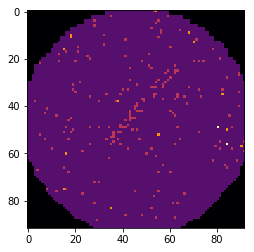

In [650]:
## внесем шум
noise_img = test.copy()
mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
mask[noise_img == 0] = False
r = np.random.poisson(lam=0.5, size=noise_img.shape)

print(np.max(r), np.min(r))
# нормировка на шумы
r = np.around(r//np.max(r))
r[r==0] = 1
noise_img[mask] = r[mask]

plt.imshow(noise_img, cmap='inferno');

## Тест прямой/кривой 

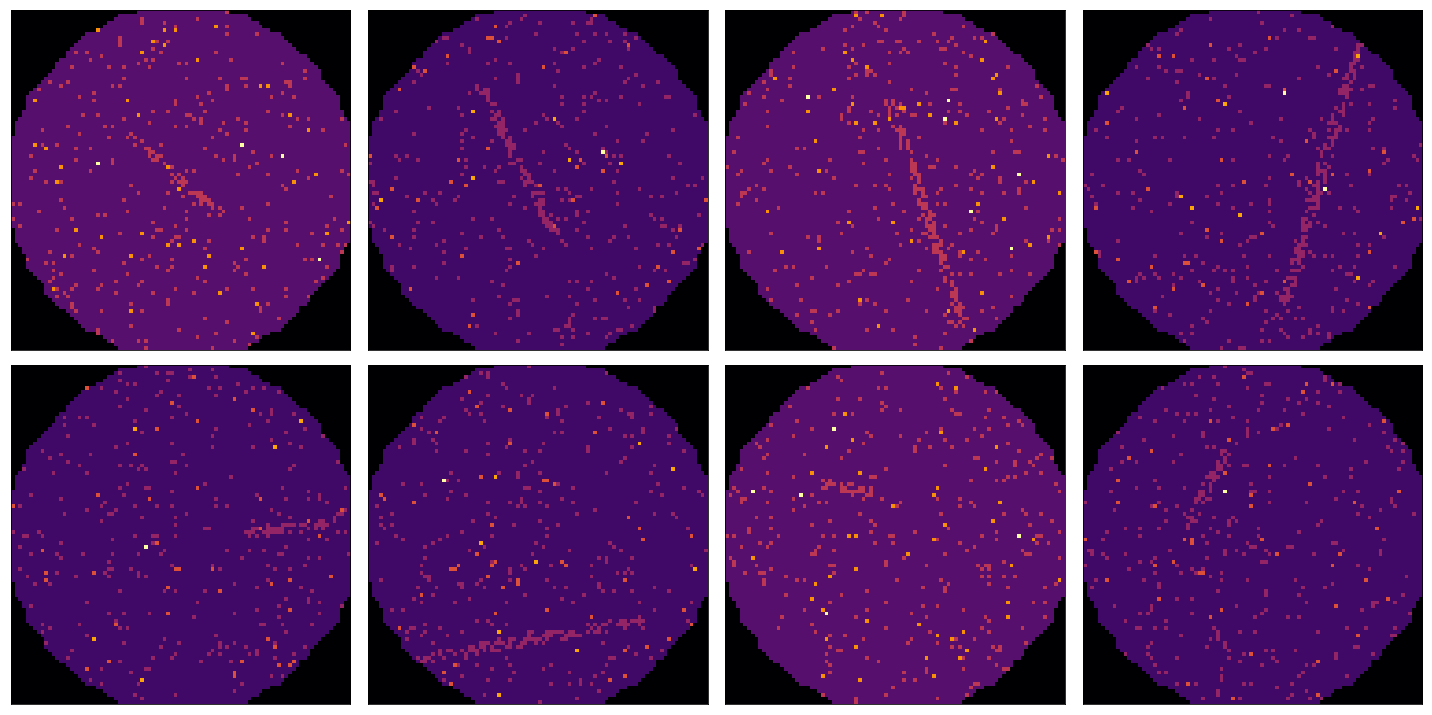

In [678]:
# Параметры сеток
## коэффиценты наклона для x, y
ALPHA_X = [1.0, 2.0, 3.0, 3.5, 
           0.1, -0.5, -0.12, 1.0]
ALPHA_Y = [1.2, 1.0, 1.0, -1.0, 
           -1.0, 3.0, -0.7, -0.5]

## центры отрезка
XC = [44 ,40, 54, 44, 44, 74, 33, 33]
YC = [44 ,40, 54, 64, 74, 44, 33, 33]
## интесивность
N = [20, 200, 200, 200, 200, 200, 200, 200]
## длина отрезка
L = [20, 20, 20, 20, 20, 20, 20, 20]

fig, ax = plt.subplots(nrows = 2, ncols = 4, figsize=(20, 10))
ax = ax.ravel(order='C')
for n in range(8):        
    xc = XC[n]
    yc = YC[n]
    t = np.linspace(-L[n]//2, L[n]//2, N[n])
    alpha_x = ALPHA_X[n]
    alpha_y = ALPHA_Y[n]
    
    ## синтез сетки
    X = alpha_x*t + xc
    Y = alpha_y*t + yc
    X_ = np.around(X)
    Y_ = np.around(Y)

    ## индексы для полигона
    points = []
    for i in range(X_.shape[0]):
        x = X_[i]
        y = Y_[i]
        points.append((x,y))

    ## создадим тестовый полигон
    test = cv2.resize(df_withpattern.waferMap[10], dsize=(92,92), interpolation=cv2.INTER_NEAREST) 
    ## 2 - паттерн
    ## 1 - фон
    ## 0 - область, где нет ничего
    test[test == 2] = 1
    for idx in points:
        i, j = idx
        i = int(round(i))
        j = int(round(j))
        test[i, j] = 2

    import cv2
    ## сверткой расширим
    kernel = np.ones((3,3), np.uint8)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=np.uint8)
    test = cv2.dilate(test,kernel,iterations = 1)

    ## внесем шум
    noise_img = test
    mask = np.random.randint(0, 2, size=noise_img.shape).astype(np.bool)
    mask[noise_img == 0] = False
    r = np.random.poisson(lam=0.5, size=noise_img.shape)

    # нормировка на шумы
    # r = np.around(r//np.max(r))
    r[r==0] = 1
    noise_img[mask] = r[mask]

    ax[n].imshow(noise_img, cmap='inferno')
    ax[n].set_xticks([])
    ax[n].set_yticks([])
plt.tight_layout()
plt.show()